### Modelling structural inference

As in Whittington et al. (2020), we model the spatial task of predicting the next location in a trajectory as the prediction of the next node in a graph. We create a large set of graphs, each one an n-by-n grid of nodes representing a simple spatial environment. Nodes are labelled with random letters to represent arbitrary associations at a particular location. Each directed edge, i.e. each possible transition in the graph, is of the type north, south, east, or west. Random walks in the set of graphs are used to train the model; these could represent sequences stored in an initial bank of memories. The generative model is trained from scratch on the replayed sequences (converted to strings of the form ‘node1 E node2 W node3 …’) with the mechanism of causal language modelling.

#### Imports:

In [1]:
# !pip install csrgraph

In [ ]:
import wandb
wandb.login()
import os
os.environ['WANDB_PROJECT'] = 'generalist_model'


wandb: Currently logged in as: carobgt (carobgt-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import csrgraph as cg
import numpy as np
import random
import string
from itertools import combinations
import pickle
import gc
import os
import json
from transformers import GPT2LMHeadModel, GPT2Tokenizer

#os.environ['WANDB_MODE'] = 'disabled'

/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import csrgraph as cg
import numpy as np
import random
import string


def get_graph(nodes = ["a", "b", "c", "d", "e", "f", "g", "h", "i"]):

    G = nx.DiGraph()
    east_pairs = [(nodes[0], nodes[1]), (nodes[1], nodes[2]), (nodes[3], nodes[4]),
                  (nodes[4], nodes[5]), (nodes[6], nodes[7]), (nodes[7], nodes[8])]
    south_pairs = [(nodes[0], nodes[3]), (nodes[3], nodes[6]), (nodes[1], nodes[4]),
                   (nodes[4], nodes[7]), (nodes[2], nodes[5]), (nodes[5], nodes[8])]
    north_pairs = [(i[1], i[0]) for i in south_pairs]
    west_pairs = [(i[1], i[0]) for i in east_pairs]

    for n in nodes:
        G.add_node(n)

   _pairs:
        G.add_edge(tple[0], tple[1], direction='NORTH')
    for tple in west_pairs:
        G.add_edge(tple[0], tple[1], direction='WEST')
    for tple in south_pairs:
        G.add_edge(tple[0], tple[1], direction='SOUTH') for tple in east_pairs:
        G.add_edge(tple[0], tple[1], direction='EAST')
    for tple in north

    return G

def get_random_walks(G, n_walks=1):
    csr_G = cg.csrgraph(G, threads=12)
    node_names = csr_G.names
    walks = csr_G.random_walks(walklen=50, # length of the walks
                    epochs=n_walks,
                    # start_nodes=list(range(0, 9)),
                    return_weight=1.,
                    neighbor_weight=1.)
    walks = np.vectorize(lambda x: node_names[x])(walks)
    return walks

def generate_n_random_walks(G, n_walks, walk_length):
    walks = []
    nodes = list(G.nodes)
    
    for _ in range(n_walks):
        walk = []
        # Start from a random node
        current_node = random.choice(nodes)
        walk.append(current_node)
        
        while len(walk) < walk_length:
            neighbors = list(G.successors(current_node))
            if not neighbors:
                break  # If the current node has no out-edges, end the walk
            next_node = random.choice(neighbors)
            walk.append(next_node)
            current_node = next_node
        
        # Convert walk to a string describing the path
        walk_str = walk_to_string(walk, G)
        walks.append(walk_str)
        
    return walks


def walk_to_string(walk, G):
    walk_string = ""
    for i in range(len(walk)-1):
        node1 = walk[i]
        node2 = walk[i+1]
        direc = G.edges[(node1, node2)]['direction']
        walk_string += str(node1) + " "+ str(direc) + " "
    walk_string += walk[-1]
    return walk_string

def generate_name() -> str:
    return ''.join(random.choices(string.ascii_lowercase, k=2))

def get_walks_as_strings(n_graphs=1000, n_walks=10, walk_length=50):
    entities_for_graphs =[[generate_name() for j in range(9)] for i in range(n_graphs)]
    
    all_graphs = []
    walks_as_strings = []
    for nodes in entities_for_graphs:
        G = get_graph(nodes=nodes)
        walks = generate_n_random_walks(G, n_walks, walk_length)
        walks_as_strings.extend(walks)
        all_graphs.append(G)
    return walks_as_strings, all_graphs

def plot_path(input_string):
    directions = {'NORTH': (0, 1), 'EAST': (1, 0), 'SOUTH': (0, -1), 'WEST': (-1, 0)}
    steps = input_string.split(' ')

    # Initialize position and label
    x, y = 0, 0
    label = steps[0]

    # List to store the trajectory (includes positions, labels, and directions)
    trajectory = [(x, y, label)]

    # Update position and label based on each step
    for i in range(1, len(steps), 2):
        movement = steps[i]
        label = steps[i + 1]
        dx, dy = directions[movement]
        x, y = x + dx, y + dy
        trajectory.append((x, y, label))

    # Plot the trajectory
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot each step in the trajectory
    for i in range(len(trajectory) - 1):
        x, y, label = trajectory[i]
        dx = trajectory[i + 1][0] - x
        dy = trajectory[i + 1][1] - y
        ax.scatter(x, y, marker='x', color='red')
        ax.text(x, y, label, fontsize=12, ha='right')

        # Draw the arrows at the middle of each line
        ax.annotate('', xy=(x + dx, y + dy), xytext=(x, y),
                     arrowprops=dict(arrowstyle="->", color='blue', connectionstyle="arc3,rad=.2"))

    # Add label and scatter for the last position
    x, y, label = trajectory[-1]
    ax.scatter(x, y, marker='x', color='red')
    ax.text(x, y, label, fontsize=12, ha='right')

    # Hide the axes but keep the grid
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xticks(range(min(x for x, _, _ in trajectory), max(x for x, _, _ in trajectory) + 1), minor=False)
    ax.set_yticks(range(min(y for _, y, _ in trajectory), max(y for _, y, _ in trajectory) + 1), minor=False)
    ax.grid(True)

    plt.show()

In [5]:
class GPT:

    def __init__(self, base_model=None, base_model_name='gpt2', vocab_size=100):
        self.base_model = base_model
        self.base_model_name = base_model_name
        self.vocab_size = vocab_size

        if self.base_model is not None:
            self.tokenizer = GPT2Tokenizer.from_pretrained(base_model)
            self.model = GPT2LMHeadModel.from_pretrained(base_model)
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def continue_input(self, input_sequence, max_new_tokens=5, num_return_sequences=1, no_repeat_ngram_size=0,
                       do_sample=False, temperature=0.7, num_beams=1):
        input_ids = self.tokenizer.encode(input_sequence, return_tensors='pt')

        # Generate text
        output = self.model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            num_return_sequences=num_return_sequences,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=do_sample,
            temperature=temperature,
        )

        # Decode the output
        sequence = output[0].tolist()
        text = self.tokenizer.decode(sequence)
        return text

In [6]:
def load_pkl(pth):
    with open(pth, 'rb') as f:
        d = pickle.load(f)
    return d

def is_valid_path(sequence, graphs):
    # Split the sequence into parts
    parts = sequence.split()

    # Extract nodes and edges; nodes are at even indices, edges at odd indices
    nodes = parts[::2]
    edges = parts[1::2]

    # Convert edges to a lowercase version for comparison (assuming all edges in graphs are lowercase)
    edges = [edge.lower() for edge in edges]

    # Iterate over each graph to check if the path exists
    for graph in graphs:
        path_exists = True
        for i in range(len(nodes) - 1):
            # Check if the current graph has the edge between the current node and the next node
            if not graph.has_edge(nodes[i], nodes[i+1]):
                path_exists = False
                break

        # If path exists in the current graph, return True
        if path_exists:
            return True

    # If none of the graphs contain the path, return False
    return False

In [10]:
def train_model_script(num_epochs=3,
                       output_dir='outputs',
                       lr=5e-05):
    gc.collect()

    # Define the save interval and total limit
    save_steps = 18900
    save_total_limit = 10 
    #checkpoint_to_resume = f'./{output_dir}/checkpoint-75600'
    #        --resume_from_checkpoint {checkpoint_to_resume} \

    train_path = f'./{output_dir}/train.txt'
    test_path = f'./{output_dir}/test.txt'
    ! python3 ./run_clm.py \
        --model_type 'gpt2' \
        --tokenizer_name 'gpt2' \
        --config_name 'gpt2' \
        --train_file {train_path} \
        --validation_file {test_path} \
        --per_device_train_batch_size 1 \
        --per_device_eval_batch_size 1 \
        --do_train \
        --do_eval \
        --output_dir {output_dir} \
        --overwrite_output_dir \
        --num_train_epochs {num_epochs} \
        --save_strategy 'steps' \
        --save_steps {save_steps} \
        --save_total_limit {save_total_limit} \
        --eval_steps 2000 \
        --learning_rate {lr} \
        --report_to 'wandb' \
        

In [11]:
import os

# Define the path for your new cache directory inside your project folder
# This will create a .cache directory where your notebook is running
project_cache_path = os.path.join(os.getcwd(), '.cache', 'huggingface_datasets')
os.makedirs(project_cache_path, exist_ok=True)

# Set the environment variable to tell the 'datasets' library to use this new path
os.environ['HF_DATASETS_CACHE'] = project_cache_path

print(f"Hugging Face datasets cache is now set to: {os.environ['HF_DATASETS_CACHE']}")

wandb_path = os.path.join(os.getcwd(), 'wandb_local_runs')
os.makedirs(wandb_path, exist_ok=True)
# Set the environment variable to tell 'wandb' to use this new path
os.environ['WANDB_DIR'] = wandb_path
print(f"Wandb local run directory set to: {os.environ['WANDB_DIR']}")

Hugging Face datasets cache is now set to: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets
Wandb local run directory set to: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/wandb_local_runs


### Spatial graph

In [13]:
!rm -rf outputs_ellie
!mkdir outputs_ellie

text_file = open("outputs_ellie/train.txt", "w")
walks, train_gs = get_walks_as_strings(n_graphs=500000, n_walks=3, walk_length=50)
#shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

text_file = open("outputs_ellie/test.txt", "w")
walks, test_gs = get_walks_as_strings(n_graphs=100, n_walks=1, walk_length=50)
#shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

In [14]:

train_model_script(num_epochs=1,
                   output_dir='outputs_ellie',
                   lr=5e-05)


/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
07/08/2025 01:32:48 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1, distributed training: False, 16-bits training: False
07/08/2025 01:32:48 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_

In [15]:
with open(f'outputs_ellie/train_graphs.pkl', 'wb') as handle:
      pickle.dump(train_gs, handle)
with open(f'outputs_ellie/test_graphs.pkl', 'wb') as handle:
      pickle.dump(test_gs, handle)

### Test trained models

Provide paths to models to test:

In [44]:
class GPT:

    def __init__(self, base_model=None, base_model_name='gpt2', vocab_size=100):
        self.base_model = base_model
        self.base_model_name = base_model_name
        self.vocab_size = vocab_size

        if self.base_model is not None:
            self.tokenizer = GPT2Tokenizer.from_pretrained(base_model)
            self.model = GPT2LMHeadModel.from_pretrained(base_model)
            # This is important for open-ended generation
            self.tokenizer.pad_token = self.tokenizer.eos_token
            self.model.config.pad_token_id = self.model.config.eos_token_id

    def continue_input(self, input_sequence, max_new_tokens=5, num_return_sequences=1, no_repeat_ngram_size=0,
                       do_sample=False, temperature=0.7, num_beams=1):
        
        # 1. Tokenize the input to get both input_ids and an attention_mask
        inputs = self.tokenizer(input_sequence, return_tensors='pt')
        input_ids = inputs.input_ids
        attention_mask = inputs.attention_mask

        # 2. Prepare generation arguments
        generation_kwargs = {
            "max_new_tokens": max_new_tokens,
            "num_return_sequences": num_return_sequences,
            "num_beams": num_beams,
            "no_repeat_ngram_size": no_repeat_ngram_size,
            "do_sample": do_sample,
            "attention_mask": attention_mask,
            "pad_token_id": self.tokenizer.eos_token_id
        }

        # 3. Only add temperature if we are doing sampling
        if do_sample:
            generation_kwargs['temperature'] = temperature

        # Generate text using keyword arguments
        output = self.model.generate(input_ids, **generation_kwargs)

        # Decode the output
        sequence = output[0].tolist()
        text = self.tokenizer.decode(sequence)
        return text

#### Test loop inferences

In [55]:
def generate_name() -> str:
    """Generate a random 2-letter name."""
    return ''.join(random.choices(string.ascii_lowercase, k=2))

def test_loop(model, loop_templates):
    accuracy_scores = []  # Store accuracy scores for each template
    results_dict = {}

    for template in loop_templates:
        template_accuracy = []  # Store accuracy for each iteration of the current template

        for _ in range(100):  # Repeat for 10 versions of each template
            # Fill the template with random names
            names = [generate_name() for _ in range(template.count("{}") - 1)]
            names += [names[0]]
            filled_template = template.format(*names)
            #print(filled_template)

            # The true final item is the last name generated
            true_final_item = names[-1]
            input_len = len(filled_template.split())

            # Use the model to predict/continue the input based on the filled template
            # Adjust the prompt as needed for your specific model and task
            prediction = model.continue_input(filled_template[0:-3],
                                              max_new_tokens=5,
                                              do_sample=False)
            #print(prediction)
            # Assuming the prediction is a string, extract the last word/item
            predicted_items = prediction.strip().split()[0:input_len]
            predicted_final_item = predicted_items[-1] if predicted_items else None
            #print(f"True final:{true_final_item}, predicted final: {predicted_final_item}")

            # Calculate accuracy for this iteration
            is_correct = int(predicted_final_item == true_final_item)
            #print(is_correct)
            template_accuracy.append(is_correct)

        # Calculate average accuracy for this template
        accuracy_scores.extend(template_accuracy)
        results_dict[template] = sum(template_accuracy) / len(template_accuracy)

    # Calculate and return the overall average accuracy
    overall_avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    return overall_avg_accuracy, results_dict


In [61]:
SPATIAL_MODEL_PATH = './new_model/'
#SPATIAL_MODEL_PATH = './spatial_model/ellie/'
#SPATIAL_MODEL_PATH = './spatial_model/'

In [56]:
# loop_templates = ["{} R {} L {}",
#                   "{} L {} R {}",
#                   "{} U {} D {}",
#                   "{} D {} U {}",
#                   "{} R {} D {} L {} U {}",
#                   "{} D {} L {} U {} R {}",
#                   "{} L {} U {} R {} D {}",
#                   "{} U {} R {} D {} L {}",
#                   "{} R {} R {} U {} L {} L {} D {}",
#                   "{} U {} U {} L {} D {} D {} R {}"]

loop_templates = ["{} EAST {} WEST {}",
                  "{} WEST {} EAST {}",
                  "{} NORTH {} SOUTH {}",
                  "{} SOUTH {} NORTH {}",
                  "{} EAST {} SOUTH {} WEST {} NORTH {}",
                  "{} SOUTH {} WEST {} NORTH {} EAST {}",
                  "{} WEST {} NORTH {} EAST {} SOUTH {}",
                  "{} NORTH {} EAST {} SOUTH {} WEST {}",
                  "{} EAST {} EAST {} NORTH {} WEST {} WEST {} SOUTH {}",
                  "{} NORTH {} NORTH {} WEST {} SOUTH {} SOUTH {} EAST {}"]

# Run the test

model = GPT(base_model=SPATIAL_MODEL_PATH, base_model_name='gpt2')
average_accuracy, spatial_results_dict = test_loop(model, loop_templates)
print(f"Average Accuracy: {average_accuracy}")

Average Accuracy: 0.8


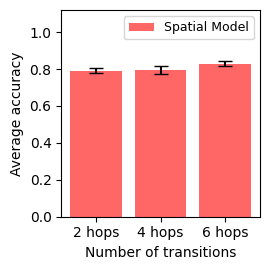

In [62]:
# Function to extract hop counts
def get_hops_count(key):
    return len(key.split()) // 2

# Create a dictionary to hold spatial results grouped by hop count
spatial_accuracies_by_hops = {}

# Populate the dictionary from your spatial_results_dict
for pattern, accuracy in spatial_results_dict.items():
    hops = get_hops_count(pattern)
    if hops not in spatial_accuracies_by_hops:
        spatial_accuracies_by_hops[hops] = []
    spatial_accuracies_by_hops[hops].append(accuracy)

# Calculate average and standard error for each hop count
hops_labels = sorted(spatial_accuracies_by_hops.keys())
mean_accuracies = [np.mean(spatial_accuracies_by_hops[h]) for h in hops_labels]
# Calculate Standard Error of the Mean (SEM)
sems = [np.std(spatial_accuracies_by_hops[h]) / np.sqrt(len(spatial_accuracies_by_hops[h])) for h in hops_labels]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(2.8, 2.8))
x = np.arange(len(hops_labels))

# Create a simple bar chart with error bars
ax.bar(x, mean_accuracies, yerr=sems, color='red', alpha=0.6, capsize=5, label='Spatial Model')

ax.set_xticks(x)
ax.set_xticklabels([f'{h} hops' for h in hops_labels])
ax.set_xlabel('Number of transitions')
ax.set_ylabel('Average accuracy')
ax.legend(loc='upper right', fontsize=9)
ax.set_ylim(0, 1.12)

plt.tight_layout()
plt.savefig('spatial_inference_by_hops.png', dpi=300) # Renamed output file
plt.show()

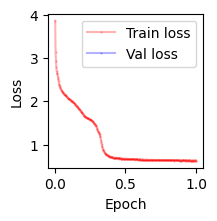

In [63]:
with open(SPATIAL_MODEL_PATH + '/trainer_state.json', 'r') as file:
    trainer_state = json.load(file)

# Extract loss values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []

for entry in trainer_state["log_history"]:
    if "loss" in entry:
        train_steps.append(entry["epoch"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_steps.append(entry["epoch"])
        eval_loss.append(entry["eval_loss"])

# Plotting the training and evaluation loss
plt.figure(figsize=(2, 2))
plt.plot(train_steps, train_loss, label='Train loss', marker='.', color='red', markersize=1, alpha=0.3)
plt.plot(eval_steps, eval_loss, label='Val loss', marker='.', color='blue', markersize=1, alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('spatial_loss.png', dpi=300, bbox_inches='tight')
plt.show()


#### Test imagination

In [64]:
def track_coordinates(walks):
    direction_offsets = {
        'U': (0, 1),
        'D': (0, -1),
        'R': (1, 0),
        'L': (-1, 0)
    }
    
    coordinates = {}
    current_position = (0, 0)
    
    for walk in walks:
        steps = walk.split()
        for i in range(0, len(steps) - 2, 2):
            node = steps[i]
            direction = steps[i + 1]
            next_node = steps[i + 2]
            
            # Check if the current node is correctly logged at the current position
            if current_position in coordinates:
                if coordinates[current_position] != node:
                    print(f"Invalid path: {node} found at {current_position}, but {coordinates[current_position]} was expected.")
                    return False
            else:
                coordinates[current_position] = node
            
            # Move to the next position
            if direction not in direction_offsets.keys():
                return False
            else:
                offset = direction_offsets[direction]
                current_position = (current_position[0] + offset[0], current_position[1] + offset[1])
                
                # Check if the next node is correctly logged at the new position
                if current_position in coordinates:
                    if coordinates[current_position] != next_node:
                        #print(f"Invalid path: {next_node} found at {current_position}, but {coordinates[current_position]} was expected.")
                        return False
                else:
                    coordinates[current_position] = next_node
    
    #print("Valid path")
    return True

# Test cases
walks1 = ['sz L zr R zr']  # This should be invalid
walks2 = ['ab R xy U yz']  # This should be valid

print(track_coordinates(walks1))  # Expected output: False
print(track_coordinates(walks2))  # Expected output: True


False
True


In [65]:
def random_letter_pair():
    return ''.join(random.choices('abcdefghijklmnopqrstuvwxyz', k=2))

model = GPT(base_model=SPATIAL_MODEL_PATH, base_model_name='gpt2')

imagined_for_temps = {}

for temp in [0, 0.5, 1.0, 1.5, 2.0]:
    imagined = []
    for i in range(50):
        if temp == 0:
            prediction = model.continue_input(random_letter_pair(), do_sample=False,
                                             max_new_tokens=50)
        else:
            prediction = model.continue_input(random_letter_pair(), do_sample=True, 
                                              max_new_tokens=50, temperature=temp)
        imagined.append(prediction)
    imagined_for_temps[temp] = imagined

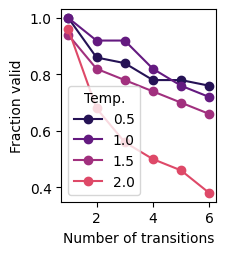

In [66]:
# Define path lengths to check
lengths = [1, 2, 3, 4, 5, 6]

# Create a figure with a specific size
plt.figure(figsize=(2, 2.5))  # You can adjust the width and height as needed

# Define a colormap
cmap = plt.get_cmap('magma')  # 'cool' is a colormap with red/blue/purple colors
colors = cmap(np.linspace(0.15, 0.75, len(imagined_for_temps)))

# Plot one line per temperature
temps_to_plot = [0.5, 1.0, 1.5, 2.0]
for idx, temp in enumerate(temps_to_plot):
    paths = imagined_for_temps[temp]
    fractions = []
    for length in lengths:
        valid_count = 0
        for path in paths:
            shortened_path = ' '.join(path.split()[:2 * length + 1])
            if track_coordinates([shortened_path]):
                valid_count += 1
        fraction_valid = valid_count / len(paths)
        fractions.append(fraction_valid)
    plt.plot(lengths, fractions, marker='o', label=f'{temp}', color=colors[idx])

# Add labels and legend
plt.xlabel('Number of transitions')
plt.ylabel('Fraction valid')
plt.legend(title='Temp.')
plt.savefig('Imagined_paths_by_temp.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import seaborn as sns

# Function to convert path to coordinates
def path_to_coordinates(path):
    x, y = 0, 0
    coordinates = [(x, y)]
    directions = {
        'U': (0, 1),
        'D': (0, -1),
        'R': (1, 0),
        'L': (-1, 0),
    }
    steps = path.split()
    for step in steps:
        if step in directions:
            dx, dy = directions[step]
            x += dx
            y += dy
            coordinates.append((x, y))
    return coordinates

fig, axs = plt.subplots(1, 3, figsize=(10, 3))  # 1 row, 3 columns

grid_size = 9 # Define the size of the grid (should be odd for symmetry)
center = grid_size // 2

# Create a heatmap for each temperature
temps_to_plot = [0, 0.5, 1.0]
for idx, temp in enumerate(temps_to_plot):
    paths = imagined_for_temps[temp]
    grid = np.zeros((grid_size, grid_size))

    for path in paths:
        coordinates = path_to_coordinates(path)
        for x, y in coordinates:
            grid[center + x, center + y] += 1

    sns.heatmap(grid, cmap='coolwarm', cbar=True, ax=axs[idx], vmin=0, vmax=250, alpha=0.7)
    axs[idx].set_title(f'Temperature of {temp}')
    axs[idx].set_xticks([])  # Remove x-ticks
    axs[idx].set_yticks([])  # Remove y-ticks

plt.tight_layout()
plt.savefig('imagined_heatmaps.png', dpi=300)
plt.show()

In [ ]:
# Function to convert path to coordinates
def path_to_coordinates(path):
    x, y = 0, 0
    coordinates = [(x, y)]
    directions = {
        'U': (0, 1),
        'D': (0, -1),
        'R': (1, 0),
        'L': (-1, 0),
    }
    steps = path.split()
    for step in steps:
        if step in directions:
            dx, dy = directions[step]
            x += dx
            y += dy
            coordinates.append((x, y))
    return coordinates

# Function to calculate the maximum distance from origin at any point in the path
def calculate_max_distance_from_origin(coordinates):
    max_distance = 0
    for (x, y) in coordinates:
        distance = abs(x) + abs(y)  # Manhattan distance
        if distance > max_distance:
            max_distance = distance
    return max_distance


# Calculate distances and mean distances
temps_to_plot = [0, 0.5, 1.0, 1.5, 2.0]
mean_distances = []
sem_distances = []
all_distances = []

for temp in temps_to_plot:
    distances = []
    paths = imagined_for_temps[temp]
    
    for path in paths:
        coordinates = path_to_coordinates(path)
        max_distance = calculate_max_distance_from_origin(coordinates)
        distances.append(max_distance)
    
    mean_distance = np.mean(distances)
    sem_distance = np.std(distances) #/ np.sqrt(len(distances))
    
    mean_distances.append(mean_distance)
    sem_distances.append(sem_distance)
    all_distances.append(distances)

# Plot bar chart with individual data points
bar_width = 0.4  # Adjust the bar width to make them thinner
plt.figure(figsize=(2, 2.5))
plt.bar(temps_to_plot, mean_distances, yerr=sem_distances, width=0.4, capsize=2, color='blue', alpha=0.4, label='Mean Distance')

# Overlay individual data points
for i, temp in enumerate(temps_to_plot):
    x_values = np.full(len(all_distances[i]), temp)  # Same x value for all points in this category
    plt.scatter(x_values, all_distances[i], color='blue', alpha=0.2, label='Individual Distances' if i == 0 else "")

plt.xlabel('Temperature')
plt.ylabel('Mean max distance')
plt.savefig('dists.png', dpi=300, bbox_inches='tight')
plt.show()


#### Can the model generalise to a larger grid?

This excludes the hypothesis that the model *just* memorises sequences of directions.

In [ ]:
def generate_name() -> str:
    """Generate a random 2-letter name."""
    return ''.join(random.choices(string.ascii_lowercase, k=2))

def test_loop(model, loop_templates):
    accuracy_scores = []  # Store accuracy scores for each template
    results_dict = {}

    for template in loop_templates:
        template_accuracy = []  # Store accuracy for each iteration of the current template

        for _ in range(50):  # Repeat for 10 versions of each template
            # Fill the template with random names
            names = [generate_name() for _ in range(template.count("{}") - 1)]
            names += [names[0]]
            filled_template = template.format(*names)
            print(filled_template)

            # The true final item is the last name generated
            true_final_item = names[-1]
            input_len = len(filled_template.split())

            # Use the model to predict/continue the input based on the filled template
            # Adjust the prompt as needed for your specific model and task
            prediction = model.continue_input(filled_template[0:-3],
                                              max_new_tokens=5,
                                              do_sample=True,
                                             temperature=1.0, num_beams=5)
            print(prediction)
            # Assuming the prediction is a string, extract the last word/item
            predicted_items = prediction.strip().split()[0:input_len]
            predicted_final_item = predicted_items[-1] if predicted_items else None
            print(f"True final:{true_final_item}, predicted final: {predicted_final_item}")

            # Calculate accuracy for this iteration
            is_correct = int(predicted_final_item == true_final_item)
            print(is_correct)
            template_accuracy.append(is_correct)

        # Calculate average accuracy for this template
        accuracy_scores.extend(template_accuracy)
        results_dict[template] = sum(template_accuracy) / len(template_accuracy)

    # Calculate and return the overall average accuracy
    overall_avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    return overall_avg_accuracy, results_dict


The model can generalise to larger grids than it was trained on to some extent (Figure X), suggesting performance cannot solely be attributed to memorisation of sequences of transitions.

In [ ]:
def create_valid_loop_templates(n):
    """
    Create all templates with n steps in one direction followed by n steps in another direction,
    ensuring that the path forms a valid loop without revisiting any location.
    """
    directions_tuples = [
        ('R', 'D', 'L', 'U'),
        ('U', 'R', 'D', 'L'),
        ('L', 'U', 'R', 'D'),
        ('D', 'L', 'U', 'R'),
    ]
    
    templates = []
    for direction_tuple in directions_tuples:
        direction_tuple = [[i]*n for i in list(direction_tuple)]
        direction_tuple = [item for sublist in direction_tuple for item in sublist]
        template = " {} ".join(direction_tuple)
        template = "{} " + template + " {}"
        templates.append(template)
    
    return templates

def create_repetition_templates(m):

    templates = []

    rep_template_1 = " {} ".join(['U'] * m + ['R'] + ['D'] * m + ['L'])
    rep_template_2 = " {} ".join(['U'] + ['R'] * m + ['D'] + ['L'] * m)
    rep_template_3 = " {} ".join(['U'] + ['L'] * m + ['D'] + ['R'] * m)
    rep_template_4 = " {} ".join(['U'] * m + ['L'] + ['D'] * m + ['R'])
    templates.append("{} " + rep_template_1 + " {}")
    templates.append("{} " + rep_template_2 + " {}")
    templates.append("{} " + rep_template_3 + " {}")
    templates.append("{} " + rep_template_4 + " {}")
    
    return templates

def generate_loop_templates(min_n=1, max_n=5):
    """
    Generate all valid loop templates with n varied between min_n and max_n.
    Also generate repetition templates for the same range of m.
    """
    templates_dict = {}
    for n in range(min_n, max_n + 1):
        templates = create_valid_loop_templates(n)
        repetition_templates = create_repetition_templates(n)
        templates_dict[n] = templates + repetition_templates
    return templates_dict

# Generate the templates
loop_templates_dict = generate_loop_templates()

# Initialize the model
model = GPT(base_model=SPATIAL_MODEL_PATH, base_model_name='gpt2')

# Test each set of templates and store the results
results = {}
for n, templates in loop_templates_dict.items():
    accuracies = []
    for template in templates:
        accuracy, _ = test_loop(model, [template])
        accuracies.append(accuracy)
    average_accuracy = np.mean(accuracies)
    sem = np.std(accuracies, ddof=1) / np.sqrt(len(accuracies))
    results[n] = (average_accuracy, sem)
    print(f"n = {n}, Average Accuracy: {average_accuracy}, SEM: {sem}")

# Extract the data for plotting
ns = list(results.keys())
mean_accuracies = [results[n][0] for n in ns]
sems = [results[n][1] for n in ns]

zk R vp D sx L uv U zk
zk R vp D sx L uv U SOUTH jz NOR
True final:zk, predicted final: SOUTH
0
xz R hy D jq L oh U xz
xz R hy D jq L oh U SOUTH zj NOR
True final:xz, predicted final: SOUTH
0
uf R pa D uj L ik U uf
uf R pa D uj L ik U WEST kz E
True final:uf, predicted final: WEST
0
ir R cx D mi L rj U ir
ir R cx D mi L rj U NORTH qg SOU
True final:ir, predicted final: NORTH
0
nn R zg D gp L bc U nn
nn R zg D gp L bc U WEST wn E
True final:nn, predicted final: WEST
0
yi R jw D pk L bh U yi
yi R jw D pk L bh U SOUTH zz NOR
True final:yi, predicted final: SOUTH
0
oz R tb D eb L ue U oz
oz R tb D eb L ue U SOUTH tb E
True final:oz, predicted final: SOUTH
0
ub R vg D bf L wq U ub
ub R vg D bf L wq U SOUTH qj NOR
True final:ub, predicted final: SOUTH
0
sj R ti D it L hd U sj
sj R ti D it L hd U SOUTH wv NOR
True final:sj, predicted final: SOUTH
0
ma R ld D bn L qq U ma
ma R ld D bn L qq U NORTH zg SOU
True final:ma, predicted final: NORTH
0
nc R pf D mx L cr U nc
nc R pf D mx L cr U SOUTH x

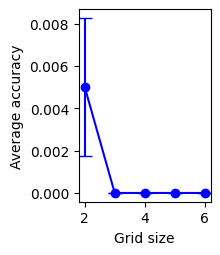

In [ ]:
# Plot the results
plt.figure(figsize=(1.7, 2.5))
plt.errorbar([n+1 for n in ns], mean_accuracies, yerr=sems, fmt='o-', capsize=5, color='b')
plt.xlabel('Grid size')
plt.ylabel('Average accuracy')
plt.savefig('accuracy_by_grid_size.png', dpi=300, bbox_inches='tight')
plt.show()
